# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to fit a neural network with 2 hidden layers.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: plots, parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Attempt two hidden layers (fully connected)
* Use validation curves to tune hyper parameters:
    * Learning Rate
    * Number of Steps
    * Dropout
    * Batch Size

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit
import itertools

import tensorflow as tf
import tensorflow.contrib.learn as skflow

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, tensorflow, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, tensorflow, numpy, pandas, matplotlib, seaborn, sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [4]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 55) (66528, 55) 




## Generate scaled features for train & test sets

In [5]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

## Generate validation set

In [6]:
nn_predictors = [0,3,1,5,2,8,4,19]

train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(gX_train[:, nn_predictors], gy_train, test_size=0.33)
test_dataset = gX_test[:, nn_predictors]
test_labels  = gy_test

In [7]:
print train_dataset.shape, valid_dataset.shape, train_labels.shape, valid_labels.shape

(89147, 8) (43909, 8) (89147,) (43909,)


# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [8]:
def test_scores(Xtrain, ytrain, Xtest, ytest, learning_rate, hidden_units, dropout, steps, batch_size):
    """
    Generate train and test scores for selected neural network.

    Parameters
    ----------
    Xtrain : array-like, shape (n_samples, n_features)
              Training vector, where n_samples is the number of samples and
              n_features is the number of features.

    ytrain : array-like, true/expected values for training set
    
    Xtest : array-like, shape (n_samples, n_features)
             Test vector, where n_samples is the number of samples and
             n_features is the number of features.

    ytest : array-like, true/expected values for test set
  
    learning_rate : self explanatory
    
    hidden_units : self explanatory
    
    dropout : self explanatory
    
    steps : self explanatory
    
    batch_size : self explanatory

    """

    # Setup optimizer, regressor
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    regressor = skflow.DNNRegressor(hidden_units=hidden_units,
                                    optimizer=optimizer,
                                    dropout=float(dropout)
                                   )

    # Fit
    regressor.fit(Xtrain, 
                  ytrain,
                  steps=steps,
                  batch_size=batch_size
                 )

    # Predict and score
    train_prediction = target_scaler.inverse_transform(regressor.predict(Xtrain))
    test_prediction  = target_scaler.inverse_transform(regressor.predict(Xtest))

    print_score(X_train['gap'], train_prediction, 
                X_test['gap'], test_prediction
               )
    

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

## Generate Validation Curves

In [9]:
def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))


def plot_validation_curve(X, y, 
                          param_name, param_range,
                          learning_list, hidden_list, dropout_list, steps_list, batch_list, 
                          plot_title, x_label, y_label):
    """
    Generate a simple plot of the validation curve for one hyperparameter.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : name of the hyper parameter that is being tested
    
    param_range : range of the hyper parameter
    
    learning_list : list of learning_rates
    
    hidden_list : list of hidden_units
    
    dropout_list : list of dropout rates
    
    steps_list : list of steps
    
    batch_list : list of batch sizes
    
    plot_title : string
            Title for the chart.
            
    x_label: label for x-axis of the plot
    
    y_label: lable for y-axis of the plot
    
    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
    """
    
    # Cross validation with 3 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=3, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    
    train_scores, test_scores = validation_curvenn(X, 
                                                   y,
                                                   cv,
                                                   learning_list,
                                                   hidden_list, 
                                                   dropout_list, 
                                                   steps_list, 
                                                   batch_list
                                                  )
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
        
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:9.2f}\tTrain Score: {2:.3f}\tCV Score: {3:.3f}' .format(param_name, float(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()
    
def validation_curvenn(X, y, cv, learning_list, hidden_list, dropout_list, steps_list, batch_list):
    """
    Generate train and validation scores for provided hyperparameter range.

    Parameters
    ----------
    estimator : tensor flow object that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, true/expected values

    cv : cross validation function to use
    
    learning_list : list of learning_rates
    
    hidden_list : list of hidden_units
    
    dropout_list : list of dropout rates
    
    steps_list : list of steps
    
    batch_list : list of batch sizes

    """
    train_scores = []
    cv_scores = []

    # Iterate over list of hyper parameters
    for learning_rate, hidden_units, dropout, steps, batch_size in itertools.product(learning_list, hidden_list, 
                                                                                     dropout_list, steps_list, batch_list):
    
        print ('Learning Rate: {0:}\tHidden Units: {1:}\tDropout: {2:}\tSteps: {3:6d}\tBatch Size: {4:5d}'
               .format(learning_rate, hidden_units, float(dropout), steps, batch_size))
        
        # Set up optimizer, regressor
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        regressor = skflow.DNNRegressor(hidden_units=hidden_units,
                                        optimizer=optimizer, 
                                        dropout=float(dropout)
                                       )
    
        train_scores_set = []
        cv_scores_set = []
        
        # Fit and generate scores
        for train_index, cv_index in cv:
            regressor.fit(X[train_index],
                          y[train_index],
                          steps=steps, 
                          batch_size=batch_size)
    
            # Predict and score
            train_prediction = regressor.predict(X[train_index])
            train_score = metrics.mean_squared_error(train_prediction, y[train_index])
            train_scores_set.append(train_score)
        
            cv_prediction = regressor.predict(X[cv_index])
            cv_score = metrics.mean_squared_error(cv_prediction, y[cv_index])
            cv_scores_set.append(cv_score)
        
        train_scores.append(train_scores_set)
        cv_scores.append(cv_scores_set)
    
    return(train_scores,cv_scores)

# Two Hidden Layers w/ Same Size as Input

## Baseline

In [10]:
# Generate baseline scores
test_scores(Xtrain=gX_train[:, nn_predictors], 
            ytrain=gy_train,
            Xtest=gX_test[:, nn_predictors], 
            ytest=gy_test,
            learning_rate=1e-4, 
            hidden_units=[8,8], 
            dropout=0, 
            steps=30000, 
            batch_size=300
            )

		MEAN^2		R2		MAPE
TRAIN     	324.931		0.830		0.919
TEST      	414.682		0.821		0.870


## Validation Curves

### Learning Rate

Learning Rate: 0.06	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.03	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.006	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.003	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.001	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.0001	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 1e-05	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Validation Curves Runtime: 0h:10m:01s


Learning Rate:      0.06	Train Score: 0.425	CV Score: 0.559
Learning Rate:      0.03	Train Score: 0.093	CV Score: 0.097
Learning Rate:      0.01	Train Score: 0.084	CV Score: 0.089
Learning Rate:      0.01	Train Score: 0.086	CV Score: 0.090
Learning Rate:      0.00	T

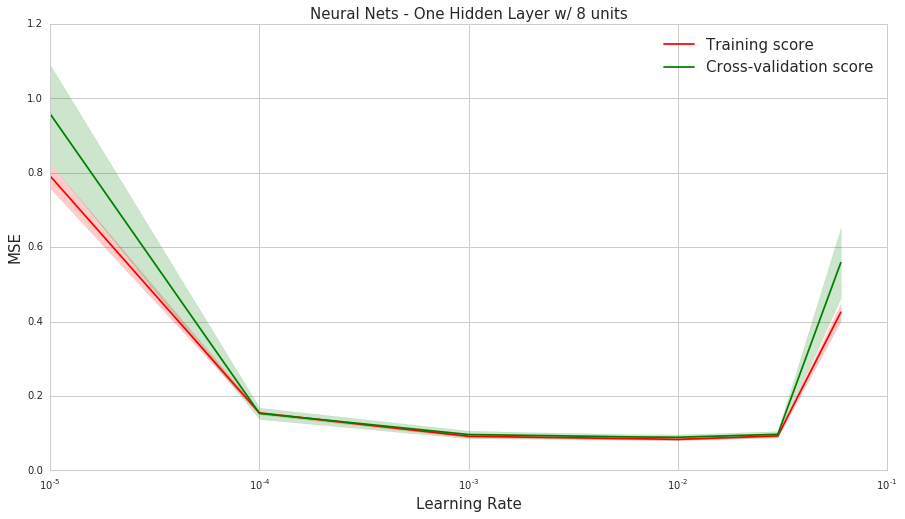

In [12]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Learning Rate', 
                      param_range=[6e-2,3e-2,1e-2,6e-3,3e-3,1e-3,1e-4,1e-5],
                      learning_list=[6e-2,3e-2,1e-2,6e-3,3e-3,1e-3,1e-4,1e-5], 
                      hidden_list=[[8, 8]], 
                      dropout_list=[0], 
                      steps_list=[30000], 
                      batch_list=[300],
                      plot_title='Neural Nets - Two Hidden Layers w/ 8 units', 
                      x_label='Learning Rate', 
                      y_label='MSE'
                     )

We will select learning rate of 0.01 that results in low training & CV scores. Learning rates higher than this lead to sharp increase in error.

### Number of Steps

Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps:    100	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps:   1000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  10000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  50000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps:  75000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps: 100000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.0	Steps: 300000	Batch Size:   300
Validation Curves Runtime: 0h:21m:58s


Number of Steps:    100.00	Train Score: 0.371	CV Score: 0.419
Number of Steps:   1000.00	Train Score: 0.113	CV Score: 0.120
Number of Steps:  10000.00	Train Score: 0.086	CV Score: 0.091
Number of Steps:  30000.00	Train Score: 0.084	CV Score: 0.089
Number of Steps:  50000.

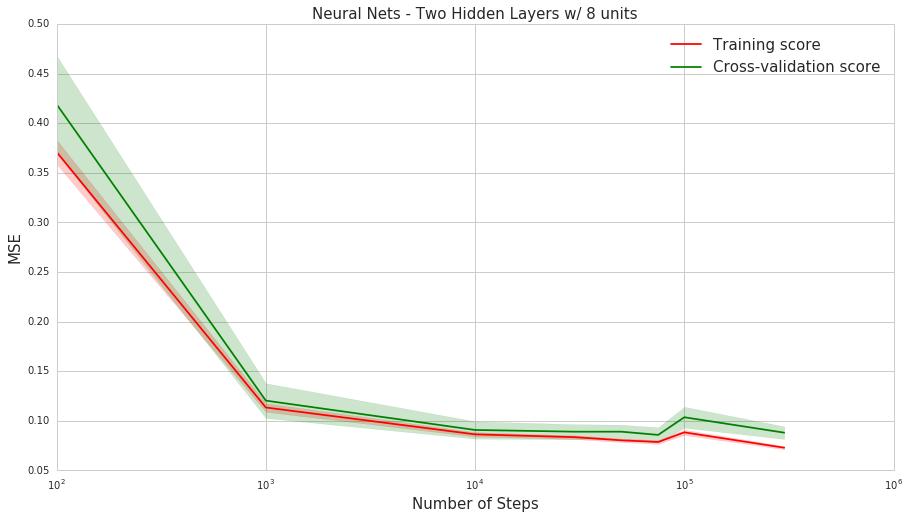

In [13]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Number of Steps', 
                      param_range=[100,1000,10000,30000,50000,75000,100000,300000],
                      learning_list=[0.01], 
                      hidden_list=[[8, 8]], 
                      dropout_list=[0], 
                      steps_list=[100,1000,10000,30000,50000,75000,100000,300000], 
                      batch_list=[300],
                      plot_title='Neural Nets - Two Hidden Layers w/ 8 units', 
                      x_label='Number of Steps', 
                      y_label='MSE'
                     )

We will select 75000 number of steps that results in low training & CV scores. Higher number of steps increase runtime without much improvement in scores.

### Dropout

Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.1	Steps:  75000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.2	Steps:  75000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.3	Steps:  75000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.4	Steps:  75000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.5	Steps:  75000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.6	Steps:  75000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.7	Steps:  75000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.8	Steps:  75000	Batch Size:  6000
Validation Curves Runtime: 2h:51m:07s


Dropout:      0.10	Train Score: 0.091	CV Score: 0.080
Dropout:      0.20	Train Score: 0.112	CV Score: 0.099
Dropout:      0.30	Train Score: 0.161	CV Score: 0.145
Dropout:      0.40	Train Score: 0.225	CV Score: 0.204
Dropout:      0.50	Train Score: 0.257	CV Score: 0.236
Dr

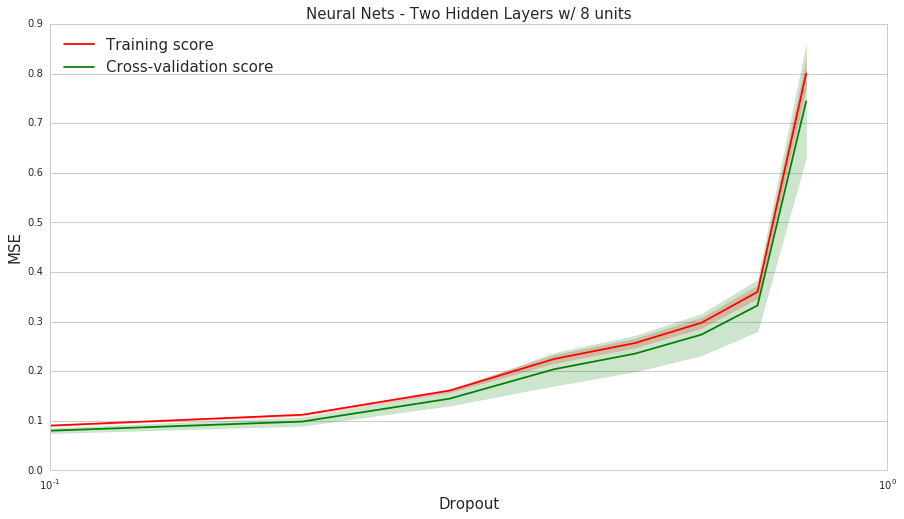

In [10]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Dropout', 
                      param_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
                      learning_list=[0.01], 
                      hidden_list=[[8, 8]], 
                      dropout_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], 
                      steps_list=[75000], 
                      batch_list=[6000],
                      plot_title='Neural Nets - Two Hidden Layers w/ 8 units', 
                      x_label='Dropout', 
                      y_label='MSE')

Lower or no dropout results in higher scores. However, using dropout ensures that the network is more robust to noise. We will select dropout of 0.1 since the scores are pretty close to the best.

### Batch Size

Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.1	Steps:  75000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.1	Steps:  75000	Batch Size:  1000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.1	Steps:  75000	Batch Size:  3000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.1	Steps:  75000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.1	Steps:  75000	Batch Size: 10000
Learning Rate: 0.01	Hidden Units: [8, 8]	Dropout: 0.1	Steps:  75000	Batch Size: 30000
Validation Curves Runtime: 2h:07m:55s


Batch Size:    300.00	Train Score: 0.093	CV Score: 0.080
Batch Size:   1000.00	Train Score: 0.090	CV Score: 0.081
Batch Size:   3000.00	Train Score: 0.097	CV Score: 0.087
Batch Size:   6000.00	Train Score: 0.091	CV Score: 0.080
Batch Size:  10000.00	Train Score: 0.092	CV Score: 0.082
Batch Size:  30000.00	Train Score: 0.094	CV Score: 0.083


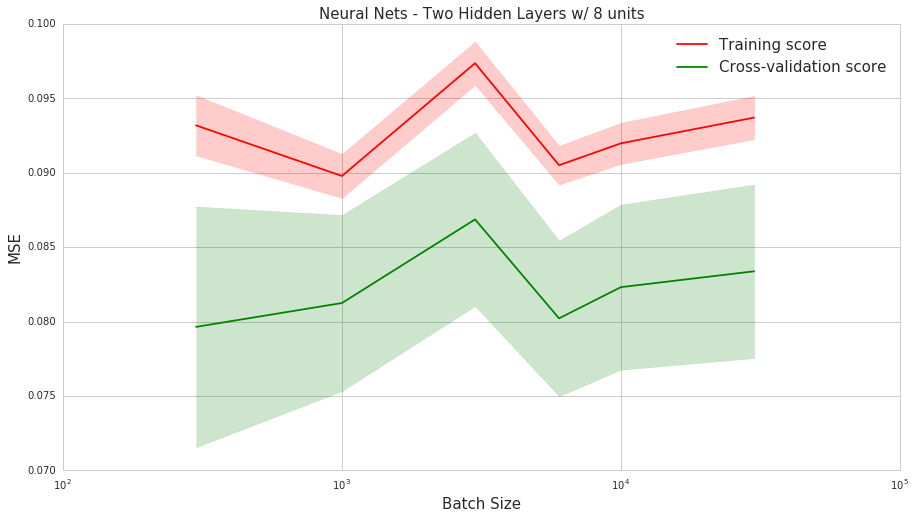

In [11]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Batch Size', 
                      param_range=[300,1000,3000,6000,10000,30000],
                      learning_list=[0.01], 
                      hidden_list=[[8, 8]], 
                      dropout_list=[0.1], 
                      steps_list=[75000], 
                      batch_list=[300,1000,3000,6000,10000,30000],
                      plot_title='Neural Nets - Two Hidden Layers w/ 8 units', 
                      x_label='Batch Size', 
                      y_label='MSE')

We will select 3000 for batch size since it produces good training & cv scores. Larger batch sizes lead to longer runtimes.

## Test Scores

In [11]:
# Use the hyper parameters selected from the validation curves
test_scores(Xtrain=gX_train[:, nn_predictors], 
            ytrain=gy_train,
            Xtest=gX_test[:, nn_predictors], 
            ytest=gy_test,
            learning_rate=0.01, 
            hidden_units=[8, 8], 
            dropout=0.1, 
            steps=75000, 
            batch_size=3000
            )

		MEAN^2		R2		MAPE
TRAIN     	190.558		0.900		0.338
TEST      	321.216		0.861		0.328
